### Dataset: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset?resource=download
### Tutorial: https://www.youtube.com/watch?v=V_xro1bcAuA&t=77134s
### Model: https://www.nature.com/articles/s41598-023-49075-4

In [39]:
!pip install tqdm
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [78]:
import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Tuple, Dict, List
import random
import os
torch.__version__

'2.2.1+cu121'

In [41]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [43]:
!nvidia-smi

Wed Mar 20 15:51:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 35%   35C    P8             35W /  400W |    7383MiB /  12288MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A        33      G   /Xwayland                                   N

In [44]:
IMAGE_PATH = "./data/melanoma"

In [45]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filesnames)} images in '{dirpath}'")

walk_through_dir("./data")

There are 1 directories and 0 images in './data'
There are 2 directories and 0 images in './data/melanoma'
There are 2 directories and 0 images in './data/melanoma/train'
There are 0 directories and 100 images in './data/melanoma/train/Benign'
There are 0 directories and 100 images in './data/melanoma/train/Malignant'
There are 2 directories and 0 images in './data/melanoma/test'
There are 0 directories and 100 images in './data/melanoma/test/Benign'
There are 0 directories and 100 images in './data/melanoma/test/Malignant'


In [46]:
image_dir = Path("./data/melanoma")
train_dir = Path("./data/melanoma/train")
test_dir = Path("./data/melanoma/test")

Random image path: data/melanoma/test/Malignant/6592.jpg
Image class is: Malignant
Image width: 224
Image height: 224


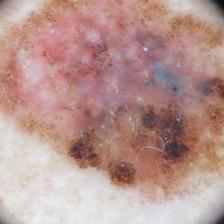

In [47]:
image_path_list = list(image_dir.glob("*/*/*.jpg"))
rand_image_path = random.choice(image_path_list)
image_class = rand_image_path.parent.stem
img = Image.open(rand_image_path)
print(f"Random image path: {rand_image_path}")
print(f"Image class is: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

(-0.5, 223.5, 223.5, -0.5)

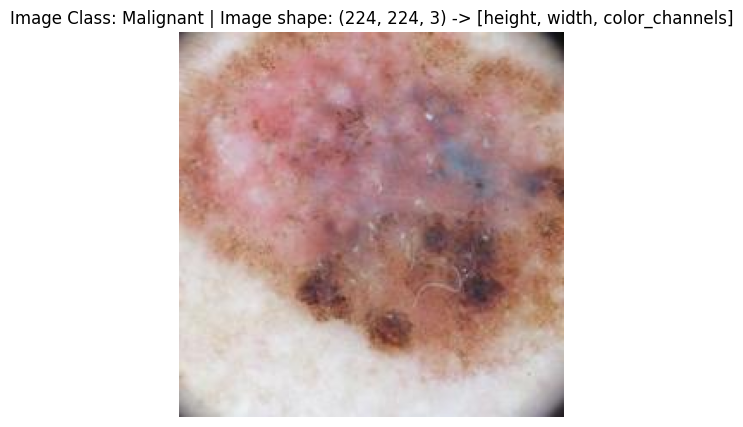

In [48]:
img_as_array = np.asarray(img)

plt.figure(figsize=(5,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [49]:
img_as_array

array([[[ 73,  62,  68],
        [ 80,  69,  73],
        [ 91,  80,  84],
        ...,
        [ 15,  17,  16],
        [ 10,  12,  11],
        [  6,   8,   5]],

       [[ 88,  75,  82],
        [ 93,  82,  86],
        [105,  93,  95],
        ...,
        [ 15,  17,  16],
        [ 12,  14,  13],
        [  8,  10,   7]],

       [[100,  85,  90],
        [104,  92,  94],
        [117, 102, 105],
        ...,
        [ 17,  19,  18],
        [ 14,  16,  15],
        [ 11,  13,  10]],

       ...,

       [[117, 112, 116],
        [124, 119, 123],
        [133, 129, 130],
        ...,
        [ 47,  42,  48],
        [ 42,  37,  41],
        [ 38,  33,  37]],

       [[102,  97, 101],
        [110, 105, 109],
        [121, 116, 120],
        ...,
        [ 42,  37,  43],
        [ 38,  33,  37],
        [ 35,  30,  34]],

       [[ 89,  84,  88],
        [ 99,  94,  98],
        [112, 107, 111],
        ...,
        [ 39,  34,  40],
        [ 36,  31,  35],
        [ 33,  28,  32]]

In [50]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5), #Augmentation helps with overfitting, not whatever is going on here
    transforms.ToTensor()
])

In [51]:
data_transform(img).shape

torch.Size([3, 224, 224])

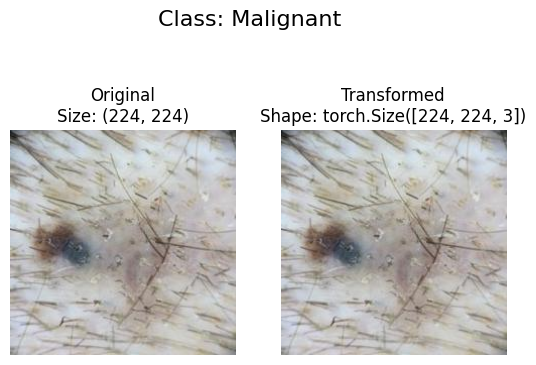

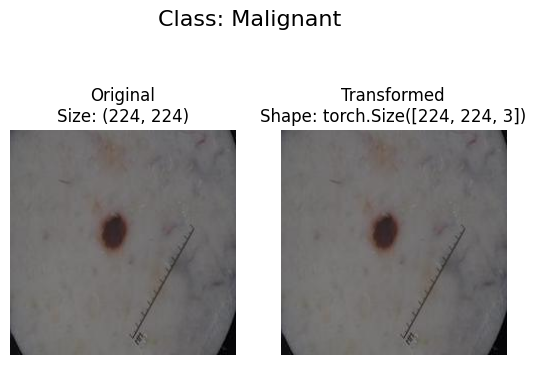

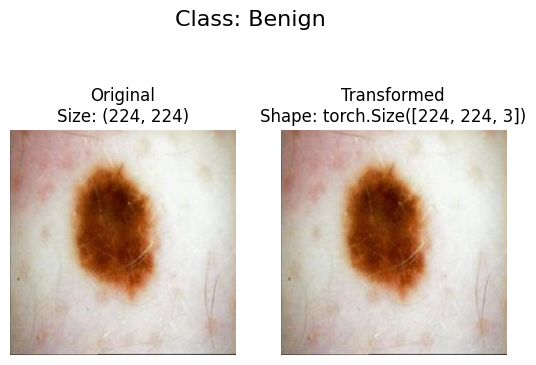

In [52]:
def plot_transformed_images(image_paths, transform, n=3):
    rand_image_paths = random.sample(image_paths, k=n)
    for image_path in rand_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3)

In [53]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/melanoma/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/melanoma/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [54]:
classes = train_data.classes
classes

['Benign', 'Malignant']

In [55]:
class_dict = train_data.class_to_idx
class_dict

{'Benign': 0, 'Malignant': 1}

In [56]:
len(train_data), len(test_data)

(200, 200)

In [57]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: data/melanoma/train


['Benign', 'Malignant']

In [58]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Counld not find the classes. Check the directory: {directory}")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

print(find_classes(train_dir))

(['Benign', 'Malignant'], {'Benign': 0, 'Malignant': 1})


In [59]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [60]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=30),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [61]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)


train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f4d2a88bd90>,
 <__main__.ImageFolderCustom at 0x7f4d2aadece0>)

In [62]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True):
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(20,20))
    for i, targ_smaple in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_smaple][0], dataset[targ_smaple][1] 
        targ_image_adjust = targ_image.permute(1,2,0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes: 
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

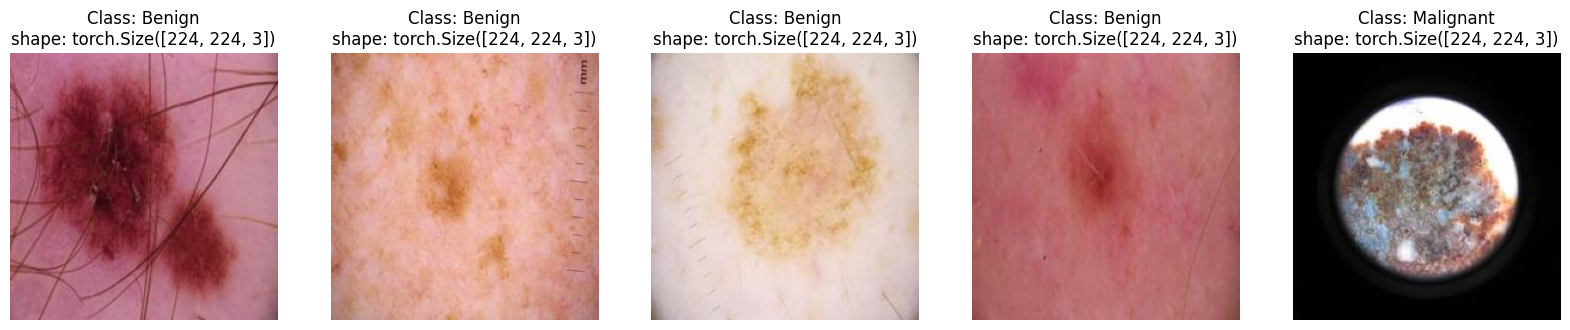

In [63]:
display_random_images(train_data,
                      n=5,
                      classes=train_data.classes)

In [64]:
BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()
train_data_loader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_data_loader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

In [65]:
img_custom, label_custom = next(iter(train_data_loader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [66]:
image_path_list

[PosixPath('data/melanoma/train/Benign/1250.jpg'),
 PosixPath('data/melanoma/train/Benign/1707.jpg'),
 PosixPath('data/melanoma/train/Benign/2719.jpg'),
 PosixPath('data/melanoma/train/Benign/3983.jpg'),
 PosixPath('data/melanoma/train/Benign/3968.jpg'),
 PosixPath('data/melanoma/train/Benign/1229.jpg'),
 PosixPath('data/melanoma/train/Benign/3351.jpg'),
 PosixPath('data/melanoma/train/Benign/3447.jpg'),
 PosixPath('data/melanoma/train/Benign/2461.jpg'),
 PosixPath('data/melanoma/train/Benign/2545.jpg'),
 PosixPath('data/melanoma/train/Benign/1696.jpg'),
 PosixPath('data/melanoma/train/Benign/5301.jpg'),
 PosixPath('data/melanoma/train/Benign/1061.jpg'),
 PosixPath('data/melanoma/train/Benign/5076.jpg'),
 PosixPath('data/melanoma/train/Benign/4328.jpg'),
 PosixPath('data/melanoma/train/Benign/4941.jpg'),
 PosixPath('data/melanoma/train/Benign/4752.jpg'),
 PosixPath('data/melanoma/train/Benign/2757.jpg'),
 PosixPath('data/melanoma/train/Benign/4440.jpg'),
 PosixPath('data/melanoma/train

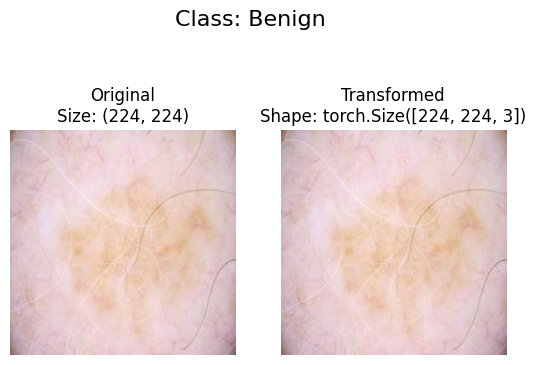

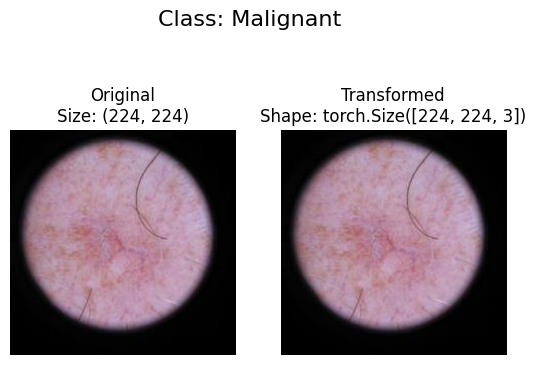

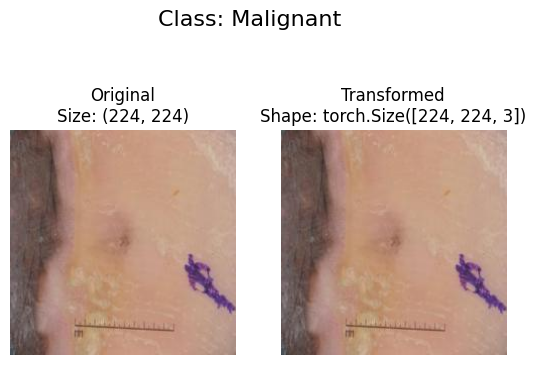

In [67]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3)

In [68]:
class TinyVGG_baseline(nn.Module):
    def __init__(self, input_shape: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_layers = nn.Sequential(
        # Layer 1
        nn.Conv2d(input_shape, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 2
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 5
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
        self.fc_layers = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, output_shape)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        out = self.fc_layers(x)
        return out
        

In [69]:
model = TinyVGG_baseline(input_shape=3,
                  output_shape=len(classes)).to(device)

In [70]:
def train_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device=device):
    
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [71]:
def test_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          device=device):
    
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss += loss.item()
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y_test).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


In [72]:
def trainer_model(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int = 5,
            device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results
    

In [73]:
LEARNING_RATE = 0.0001
EPOCHS = 25
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [74]:
start_time = timer()
model_results = trainer_model(model=model,
                        train_dataloader=train_data_loader_custom,
                        test_dataloader=test_data_loader_custom,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=EPOCHS,
                        device=device)
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds on {device}")

  4%|▍         | 1/25 [00:03<01:26,  3.60s/it]

Epoch: 0 | Train Loss: 0.6972 | Train Accuracy: 0.4554 | Test Loss: 0.6916 | Test Accuracy: 0.5536


  8%|▊         | 2/25 [00:06<01:18,  3.43s/it]

Epoch: 1 | Train Loss: 0.6947 | Train Accuracy: 0.4732 | Test Loss: 0.6949 | Test Accuracy: 0.4464


 12%|█▏        | 3/25 [00:10<01:14,  3.36s/it]

Epoch: 2 | Train Loss: 0.6938 | Train Accuracy: 0.4821 | Test Loss: 0.6934 | Test Accuracy: 0.4464


 16%|█▌        | 4/25 [00:13<01:10,  3.34s/it]

Epoch: 3 | Train Loss: 0.6927 | Train Accuracy: 0.5312 | Test Loss: 0.6922 | Test Accuracy: 0.5536


 20%|██        | 5/25 [00:16<01:06,  3.34s/it]

Epoch: 4 | Train Loss: 0.6894 | Train Accuracy: 0.5268 | Test Loss: 0.6766 | Test Accuracy: 0.5536


 24%|██▍       | 6/25 [00:20<01:02,  3.31s/it]

Epoch: 5 | Train Loss: 0.6622 | Train Accuracy: 0.5268 | Test Loss: 0.6594 | Test Accuracy: 0.5536


 28%|██▊       | 7/25 [00:23<00:58,  3.27s/it]

Epoch: 6 | Train Loss: 0.6015 | Train Accuracy: 0.5134 | Test Loss: 0.6647 | Test Accuracy: 0.5536


 32%|███▏      | 8/25 [00:26<00:55,  3.26s/it]

Epoch: 7 | Train Loss: 0.6854 | Train Accuracy: 0.7366 | Test Loss: 0.6835 | Test Accuracy: 0.5848


 36%|███▌      | 9/25 [00:29<00:52,  3.29s/it]

Epoch: 8 | Train Loss: 0.6256 | Train Accuracy: 0.6696 | Test Loss: 0.6932 | Test Accuracy: 0.5000


 40%|████      | 10/25 [00:33<00:49,  3.31s/it]

Epoch: 9 | Train Loss: 0.6638 | Train Accuracy: 0.6161 | Test Loss: 0.6756 | Test Accuracy: 0.5000


 44%|████▍     | 11/25 [00:36<00:45,  3.28s/it]

Epoch: 10 | Train Loss: 0.6321 | Train Accuracy: 0.5982 | Test Loss: 0.6901 | Test Accuracy: 0.5268


 48%|████▊     | 12/25 [00:39<00:42,  3.26s/it]

Epoch: 11 | Train Loss: 0.6799 | Train Accuracy: 0.6920 | Test Loss: 0.7882 | Test Accuracy: 0.5848


 52%|█████▏    | 13/25 [00:42<00:38,  3.25s/it]

Epoch: 12 | Train Loss: 0.5054 | Train Accuracy: 0.7411 | Test Loss: 0.6894 | Test Accuracy: 0.5536


 56%|█████▌    | 14/25 [00:46<00:35,  3.23s/it]

Epoch: 13 | Train Loss: 0.7169 | Train Accuracy: 0.5000 | Test Loss: 0.6678 | Test Accuracy: 0.5536


 60%|██████    | 15/25 [00:49<00:32,  3.22s/it]

Epoch: 14 | Train Loss: 0.6504 | Train Accuracy: 0.5268 | Test Loss: 0.6462 | Test Accuracy: 0.5536


 64%|██████▍   | 16/25 [00:52<00:29,  3.24s/it]

Epoch: 15 | Train Loss: 0.5271 | Train Accuracy: 0.6741 | Test Loss: 0.8363 | Test Accuracy: 0.7277


 68%|██████▊   | 17/25 [00:55<00:25,  3.22s/it]

Epoch: 16 | Train Loss: 0.5161 | Train Accuracy: 0.8214 | Test Loss: 0.6868 | Test Accuracy: 0.5714


 72%|███████▏  | 18/25 [00:58<00:22,  3.22s/it]

Epoch: 17 | Train Loss: 0.4583 | Train Accuracy: 0.7991 | Test Loss: 0.8507 | Test Accuracy: 0.7500


 76%|███████▌  | 19/25 [01:02<00:19,  3.24s/it]

Epoch: 18 | Train Loss: 0.3909 | Train Accuracy: 0.8795 | Test Loss: 0.7750 | Test Accuracy: 0.6027


 80%|████████  | 20/25 [01:05<00:16,  3.25s/it]

Epoch: 19 | Train Loss: 0.3600 | Train Accuracy: 0.8393 | Test Loss: 1.1404 | Test Accuracy: 0.6473


 84%|████████▍ | 21/25 [01:08<00:13,  3.25s/it]

Epoch: 20 | Train Loss: 0.4498 | Train Accuracy: 0.8348 | Test Loss: 0.6867 | Test Accuracy: 0.6964


 88%|████████▊ | 22/25 [01:11<00:09,  3.24s/it]

Epoch: 21 | Train Loss: 0.3524 | Train Accuracy: 0.8616 | Test Loss: 0.5728 | Test Accuracy: 0.7054


 92%|█████████▏| 23/25 [01:15<00:06,  3.24s/it]

Epoch: 22 | Train Loss: 0.3229 | Train Accuracy: 0.8571 | Test Loss: 0.8224 | Test Accuracy: 0.7009


 96%|█████████▌| 24/25 [01:18<00:03,  3.23s/it]

Epoch: 23 | Train Loss: 0.4368 | Train Accuracy: 0.8304 | Test Loss: 0.5516 | Test Accuracy: 0.7366


100%|██████████| 25/25 [01:21<00:00,  3.26s/it]

Epoch: 24 | Train Loss: 0.4486 | Train Accuracy: 0.7411 | Test Loss: 0.8852 | Test Accuracy: 0.5804
Total Training Time: 81.570 seconds on cuda


In [75]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

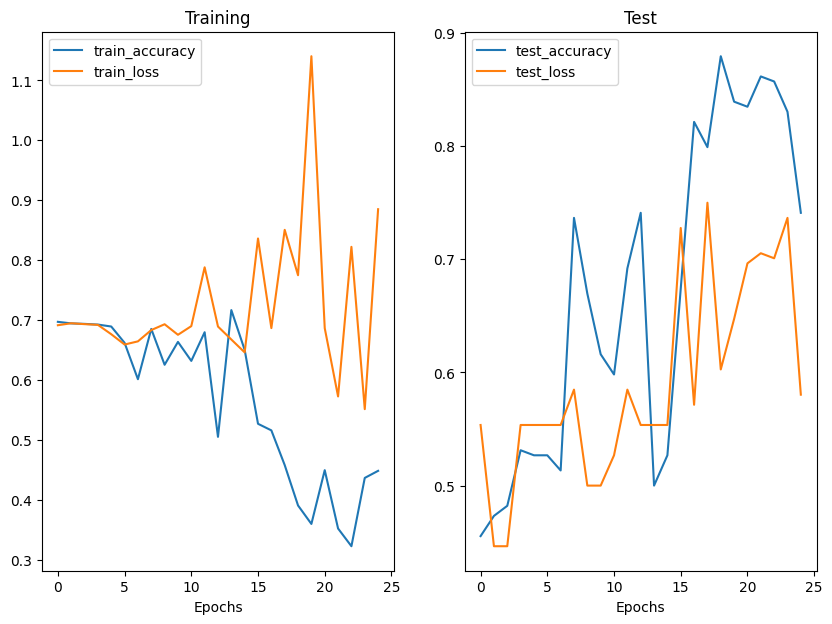

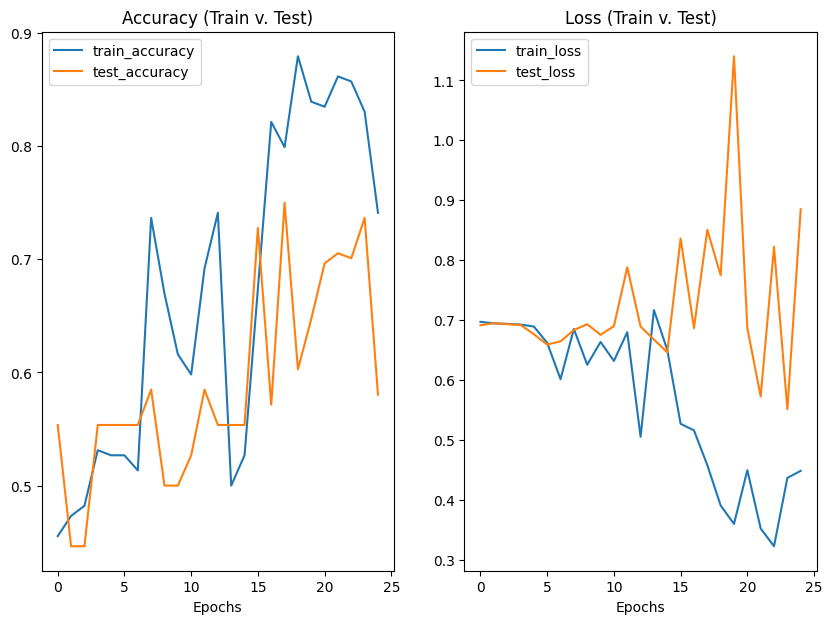

In [76]:
def plot_results_dict(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_accuracy")
    plt.plot(epochs, test_loss, label="train_loss")
    plt.title("Training")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="test_accuracy")
    plt.plot(epochs, test_accuracy, label="test_loss")
    plt.title("Test")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy (Train v. Test)")
    plt.xlabel("Epochs")
    plt.legend()

    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss (Train v. Test)")
    plt.xlabel("Epochs")
    plt.legend()

plot_results_dict(model_results)

In [80]:
custom_test_image_path = Path("../../datasets/melanoma/full_test/Malignant/5602.jpg")
custom_image = torchvision.io.read_image(str(custom_test_image_path)).type(torch.float32) / 255

custom_image

tensor([[[0.5608, 0.5647, 0.5686,  ..., 0.4392, 0.4314, 0.4275],
         [0.5647, 0.5686, 0.5765,  ..., 0.4431, 0.4353, 0.4314],
         [0.5725, 0.5725, 0.5882,  ..., 0.4510, 0.4431, 0.4392],
         ...,
         [0.3922, 0.3922, 0.3922,  ..., 0.5608, 0.5569, 0.5569],
         [0.3843, 0.3882, 0.3882,  ..., 0.5569, 0.5490, 0.5451],
         [0.3804, 0.3843, 0.3843,  ..., 0.5569, 0.5451, 0.5451]],

        [[0.4275, 0.4314, 0.4353,  ..., 0.2275, 0.2196, 0.2157],
         [0.4314, 0.4353, 0.4431,  ..., 0.2314, 0.2235, 0.2196],
         [0.4353, 0.4353, 0.4431,  ..., 0.2314, 0.2235, 0.2196],
         ...,
         [0.1529, 0.1529, 0.1529,  ..., 0.3490, 0.3412, 0.3412],
         [0.1451, 0.1490, 0.1490,  ..., 0.3451, 0.3451, 0.3412],
         [0.1412, 0.1451, 0.1451,  ..., 0.3451, 0.3412, 0.3412]],

        [[0.3922, 0.3961, 0.4000,  ..., 0.2196, 0.2118, 0.2078],
         [0.3961, 0.4000, 0.4078,  ..., 0.2235, 0.2157, 0.2118],
         [0.4118, 0.4118, 0.4196,  ..., 0.2275, 0.2196, 0.

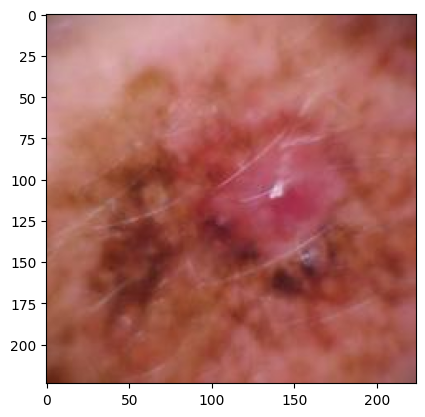

In [81]:
plt.imshow(custom_image.permute(1,2,0))

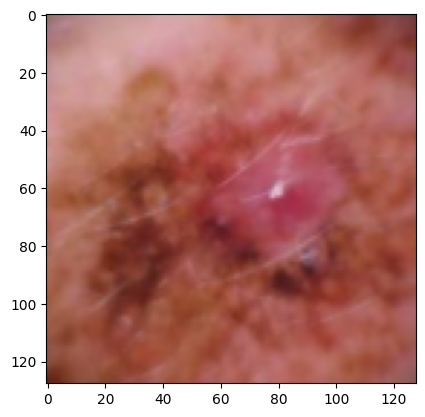

In [86]:
custom_image_transform = transforms.Compose([transforms.Resize(size=(128,128))
])
custom_image_transformed = custom_image_transform(custom_image)
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
custom_image_transformed = custom_image_transformed.unsqueeze()
model.eval()
with torch.inference_mode():
    custom_image_pred = model(custom_image_transformed.to(device))